## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 

<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

# Detección de sarcasmo
Para este ejercicio vas a utilizar el dataset del paper [A Large Self-Annotated Corpus for Sarcasm](https://arxiv.org/abs/1704.05579), con un millón de comentarios de Reddit, etiquetados como sarcásticos o no sarcásticos. Se pide:
1. Si hubiese missings, eliminalos


In [1]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('../dataNLP/Prof/train-balanced-sarcasm.csv')

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

Este conjunto de datos contiene 1,3 millones de comentarios sarcásticos del sitio web de comentarios de Internet Reddit. El conjunto de datos se generó extrayendo comentarios de Reddit (no por mí :)) que contienen la etiqueta \s (sarcasmo). Los Redditors suelen utilizar esta etiqueta para indicar que su comentario es una broma y no debe tomarse en serio, y generalmente es un indicador confiable del contenido de un comentario sarcástico.

1.Primer análisis

In [3]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
df.tail()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...
1010825,1,"values, as in capitalism .. there is good mone...",frogking,politics,2,2,0,2009-01,2009-01-24 06:20:14,Why do the people who make our laws seem unabl...


In [5]:
df.shape

(1010826, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [7]:
df.duplicated().sum()

28

In [8]:
df.isna().sum()

label              0
comment           55
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

Limpieza

Eliminaremos los valores duplicados del dataframe y los valores de comment duplicados

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(1010798, 10)

Los 55 valores nulos están en nuestra columna comment que es de la que queremos detectar el sarcasmo asi que los borramos

In [11]:
df.dropna(inplace=True)

In [12]:
df.shape

(1010743, 10)

In [13]:
#Función para visualización

def grafico_histbox(column, df):
    # Crear figura y ejes de subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Gráfico de distribución (histograma)
    sns.histplot(df[column], kde=True, ax=axs[0])
    axs[0].set_title(f'Distribución de la variable {column}')
    axs[0].set_xlabel(f'Valores de {column}')
    axs[0].set_ylabel('Frecuencia')

    # Gráfico de análisis univariante (boxplot)
    mean = df[column].mean()
    median = df[column].median()
    sns.boxplot(x=df[column], ax=axs[1])
    axs[1].axvline(mean, color='g', linestyle='-', label=f'Mean={mean:.1f}')
    axs[1].axvline(median, color='r', linestyle='-', label=f'Median={median:.1f}')
    axs[1].legend()
    axs[1].set_title(f'Análisis Univariante de {column}')
    axs[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()

def grafico_countplot(column,df):

    custom_palette = sns.color_palette("husl", len(df[column].unique()))
    sns.countplot(x=column, hue=column, data=df, palette=custom_palette, stat='percent')

    return plt.show()

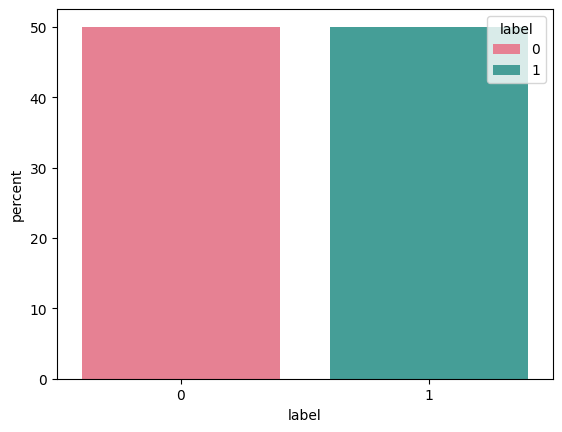

In [14]:
grafico_countplot('label',df)

1 significa que es sarcastico y 0 no sarcastico

In [15]:
df['label'].value_counts()

label
0    505403
1    505340
Name: count, dtype: int64

Limpieza

In [16]:
import re

# Definir una función para limpiar los comentarios
def limpiar_comentarios(comment):
    # Utilizar una expresión regular para eliminar caracteres no alfanuméricos, pero preservar espacios
    return re.sub(r'[^\w\s]', '', comment)

# Aplicar la función a la columna 'comment' y asignar los resultados nuevamente
df['comment'] = df['comment'].apply(limpiar_comentarios)

In [17]:
df['parent_comment'] = df['parent_comment'].apply(limpiar_comentarios)

In [18]:
df['comment'].head()

0                                            NC and NH
1    You do know west teams play against west teams...
2    They were underdogs earlier today but since Gr...
3    This meme isnt funny none of the new york nigg...
4                       I could use one of those tools
Name: comment, dtype: object

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/itziarc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
from nltk.corpus import stopwords

spanish_stopwords = stopwords.words('english')

In [21]:
def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

In [22]:
df['comment'] = df['comment'].apply(remove_stopwords)
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC NH,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,Yeah I get that argument At this point Id pref...
1,0,You know west teams play west teams east teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks The wests 5 and 6 se...
2,0,They underdogs earlier today since Gronks anno...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,Theyre favored to win
3,0,This meme isnt funny none new york nigga ones,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass dont kill my buzz
4,0,I could use one tools,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [23]:
df['parent_comment'] = df['parent_comment'].apply(remove_stopwords)
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC NH,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,Yeah I get argument At point Id prefer lived N...
1,0,You know west teams play west teams east teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers Mavericks The wests 5 6 seed even ...
2,0,They underdogs earlier today since Gronks anno...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,Theyre favored win
3,0,This meme isnt funny none new york nigga ones,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass dont kill buzz
4,0,I could use one tools,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep confirm I saw tool use It made boy EASport...


In [24]:
from nltk.stem.snowball import SnowballStemmer

def spanish_stemmer(x):
    stemmer = SnowballStemmer('english')
    return " ".join([stemmer.stem(word) for word in x.split()])

df['comment'] = df['comment'].apply(spanish_stemmer)
df['comment'].head()

0                                                nc nh
1    you know west team play west team east team right
2    they underdog earlier today sinc gronk announc...
3         this meme isnt funni none new york nigga one
4                                 i could use one tool
Name: comment, dtype: object

In [25]:
df['parent_comment'] = df['parent_comment'].apply(spanish_stemmer)
df['comment'].head()

0                                                nc nh
1    you know west team play west team east team right
2    they underdog earlier today sinc gronk announc...
3         this meme isnt funni none new york nigga one
4                                 i could use one tool
Name: comment, dtype: object

Modelo

In [26]:
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

# Obtener los conjuntos de entrenamiento y validación con las columnas 'comment' y 'parent_comment'
X_train = train_data[['comment', 'parent_comment']]
X_val = val_data[['comment', 'parent_comment']]
y_train = train_data['label']
y_val = val_data['label']

In [31]:
X_train.shape

(808594, 2)

In [32]:
y_train.shape

(808594,)

In [29]:
tf_f=TfidfVectorizer()
lr=LogisticRegression()
pipeline= Pipeline([('tf_f',tf_f),('lr',lr)])

In [30]:
pipeline.fit(X_train_conca,y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tf_f', TfidfVectorizer()), ('lr', LogisticRegression())])

In [31]:
predic = pipeline.predict(X_val)

In [29]:
print(classification_report(y_val, predic))
print("Accuracy Score:", accuracy_score(y_val, predic))

              precision    recall  f1-score   support

           0       0.67      0.72      0.70    126074
           1       0.70      0.65      0.67    126612

    accuracy                           0.68    252686
   macro avg       0.69      0.68      0.68    252686
weighted avg       0.69      0.68      0.68    252686

Accuracy Score: 0.6842009450464213


In [33]:
conf_matrix = confusion_matrix(y_val, predic)

In [34]:
conf_matrix

array([[69335, 31496],
       [37891, 63427]])